# Chapter 3 Exercises

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import datasets, neighbors, preprocessing, \
    pipeline, model_selection, metrics
import matplotlib.pyplot as plt
%matplotlib inline

First, some data fetching and preparation

In [2]:
ds_name = "mnist_784"
mnist = datasets.fetch_openml(ds_name)

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
split_ix = 60000
X_train_raw = X[:split_ix]
y_train = y[:split_ix]
X_test_raw = X[split_ix:]
y_test = X[split_ix:]

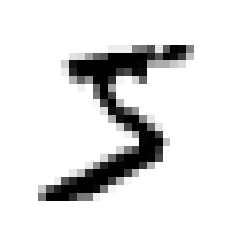

In [6]:
plot_ix = 0
plt.imshow(X_train_raw[plot_ix].reshape(28,28), cmap="binary")
plt.axis("off");

## Exercise 1
Try to fit a classifier that achieves >97% accuracy on the test set (last 10,000 rows of the MNIST 784 data).

The first classifier that I investigated was KNN, for no particular reason.  In fact, KNN should stand out as not being a great classifier for this problem, due to the high dimensionality (784 features) of the data.  In a setting with so many dimensions, all points will tend to be relatively far from the origin and the usefulness of Euclidean distance as a description of "closeness" starts to break down.  Nevertheless, I thought I would try it out just to try it out.  If anything, KNN is one of the simplest classification algorithnms that navtively supports multiclass classification, which is what we're interested in with the MNIST digits dataset.

In fact, there is another reason why KNN is a risky algorithm to try, at least as implemented in `sklearn`.  The implementation of the `KNeighborsClassifier` has a few "helpful" tricks under the hood to help speed up nearest-neighbor searches.  The search, i.e. the predicting function of the classifier, is where the bulk of the computation is.  _Fitting_ the model more or less just reduces to storing a representation of the data, while _predicting_ requires querying the data for the K nearest neighbors.  Without applying any clever "tricks", this querying is an `O(n)` operation because a new point must be evaluated against each training point.

`KNeighborsClassifier` supports some tricks that are meant to speed up this query time, by storing the training data in a tree structure instead of just as-is.  Two of these alternate representations are available: `KDTree` and `BallTree`, each with their own strengths and weaknesses.  Both of them share a weakness: they are much slower than simple brute-forcing the query when the dimensionaility is as high as it is in this dataset.  The `sklearn` documentation declares that, if no algorithm is passed at fit-time (i.e. the default `algorithm='auto'` is used), `KNeighborsClassifier` will try to determine the best algorithm to use.  On this dataset, `sklearn` totally whiffs: `kdtree` is determined to be the best algorithm to use, but computation performance is awful with 784 dimensions to contend with.  3-fold cross validation on the entire train set with `algorithm='brute'` takes less than three minutes on my laptop; letting the `auto` option select `algorithm='kd_tree'` takes so long that I haven't yet had the patience to let the cell run through.

Of course, the curse of dimensionality stil prevents the classifier from achieveing an accuracy above 97%.  Despite `KNeighborsClassifier` not being the best tool for the job, it is helpful to know about the different options for producing a prediciton, and where their strengths and weaknesses are.

In [7]:
# Distances need to be scaled to prevent the measurement
# scale from affecting the fit
pipe = pipeline.Pipeline([
    ("scaler", preprocessing.StandardScaler())
])

In [8]:
X_train = pipe.fit_transform(X_train_raw)

In [50]:
nrows = 1000

In [51]:
algo = 'brute'
knn_clf = neighbors.KNeighborsClassifier()
param_grid = [
    {"n_neighbors": [5], "algorithm": [algo]},  # 5 is the default value
]
cv = 3
start = time.time()
grid_search_brute = model_selection.GridSearchCV(knn_clf, param_grid, cv=cv)
grid_search_brute.fit(X_train[:nrows], y_train[:nrows])
end = time.time()
print(f"Grid search took {round(end-start, 5)} seconds using algorithm: '{algo}' on {nrows} training rows")

Grid search took 0.11968 seconds using algorithm: 'brute' on 1000 training rows


In [52]:
algo = 'ball_tree'
knn_clf = neighbors.KNeighborsClassifier()
param_grid = [
    {"n_neighbors": [5], "algorithm": [algo]},
]
cv = 3
start = time.time()
grid_search_balltree = model_selection.GridSearchCV(knn_clf, param_grid, cv=cv)
grid_search_balltree.fit(X_train[:nrows], y_train[:nrows])
end = time.time()
print(f"Grid search took {round(end-start, 5)} seconds using algorithm: '{algo}' on {nrows} training rows")

Grid search took 1.03025 seconds using algorithm: 'ball_tree' on 1000 training rows


In [53]:
algo = 'kd_tree'
knn_clf = neighbors.KNeighborsClassifier()
param_grid = [
    {"n_neighbors": [5], "algorithm": [algo]},
]
cv = 3
start = time.time()
grid_search_kdtree = model_selection.GridSearchCV(knn_clf, param_grid, cv=cv)
grid_search_kdtree.fit(X_train[:nrows], y_train[:nrows])
end = time.time()
print(f"Grid search took {round(end-start, 5)} seconds using algorithm: '{algo}' on {nrows} training rows")

Grid search took 1.44563 seconds using algorithm: 'kd_tree' on 1000 training rows


In [58]:
def knn_scaling(nrows_arr, algos):
    """Docstring"""
    searches = {}
    cv = 3
    for algo in algos:
        searches[algo] = {}
        for nrow in nrows_arr:
            knn_clf = neighbors.KNeighborsClassifier()
            param_grid = [{"n_neighbors": [5], "algorithm": [algo]}]
            grid_search = model_selection.GridSearchCV(knn_clf, param_grid, cv=cv)
            grid_search.fit(X_train[:nrow], y_train[:nrow])
            searches[algo][nrow] = grid_search
    return searches

In [60]:
nrows_arr = [100, 1000, 5000]
algos = ["brute", "ball_tree", "kd_tree"]
start= time.time()
searches = knn_scaling(nrows_arr, algos)
end = time.time()
print(f"Searches took {round(end-start)} seconds")

Searches took 51 seconds


In [156]:
def plot_scaling(searches):
    algos = list(searches.keys())
    nrows = list(searches[algos[0]].keys())  # Assumes they're the same across algos
    group_ixs = range(len(nrows))
    group_width = 0.35
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for incr, algo in enumerate(algos):
        
        times = [gs.cv_results_["mean_fit_time"][0] for gs in searches[algo].values()]
        stds = [gs.cv_results_["std_fit_time"][0] for gs in searches[algo].values()]
        width = group_width / len(algos)
        ixs = [ix + (width * incr) for ix in group_ixs]
        ax.bar(ixs, times, width=width, yerr=stds, zorder=2);
        
    ax.set_xticklabels(nrows)
    plt.yscale("log")
    plt.grid(True, which="major", axis="y", zorder=1)
    plt.grid(True, which="minor", axis="y", linestyle="--", zorder=1)

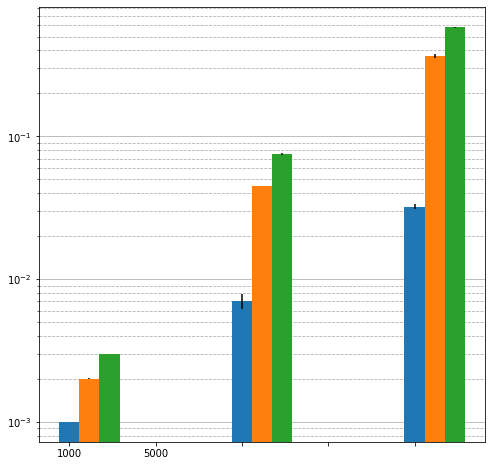

In [157]:
plot_scaling(searches)

`kd_tree` scales worse than `ball_tree` and much worse than `brute` on this data set.  It seems to me that the `sklearn` implementation of `KNeighborsClassifier` should take dimensionality into account when determining which algorithm to automatically select when `algorithm='auto'`.

In [121]:
knn_clf = neighbors.KNeighborsClassifier()
param_grid = [{"algorithm": ["brute"], "n_neighbors": [1, 3, 5], "weights": ["uniform", "distance"]}]
cv = 6

start = time.time()
grid_search = model_selection.GridSearchCV(knn_clf, param_grid, cv=cv, verbose=5, n_jobs=-1)
grid_search.fit(X_train[:30000], y_train[:30000])
end = time.time()
print(f"Grid search took {round(end-start)} seconds")

Fitting 6 folds for each of 6 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.6min finished


Grid search took 336 seconds


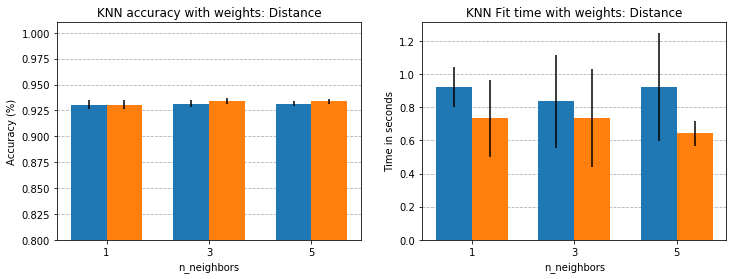

In [122]:
# Plot the results

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sc_ax, time_ax = axs[0], axs[1]


params_searched = grid_search.cv_results_["params"]
meantimes = grid_search.cv_results_["mean_fit_time"]
stdtimes = grid_search.cv_results_["std_fit_time"]
meanscores = grid_search.cv_results_["mean_test_score"]
stdscores = grid_search.cv_results_["std_test_score"]
weights = ["uniform", "distance"]

d = {}
for i, p in enumerate(params_searched):
    n_neibs = p["n_neighbors"]
    meantime = meantimes[i]
    stdtime = stdtimes[i]
    meanscore = meanscores[i]
    stdscore = stdscores[i]
    weight = p["weights"]
    row = [i, n_neibs, meantime, stdtime, meanscore, stdscore]
    if not d.get(weight):
        d[weight] = []
    d[weight].append(row)

width = 0.35
for i, weight in enumerate(d.keys()):
    offset = (((i*2)-1) * width/2)
    bar_ixs = [x + offset for x in range(len(d[weight]))]
    label_ixs = [x for x in range(len(d[weight]))]
    xticklabels = [r[1] for r in d[weight]]
    
    times_mu = [r[2] for r in d[weight]]
    times_sigma = [r[3] for r in d[weight]]
    time_ax.bar(bar_ixs, times_mu, yerr=times_sigma, width=width, zorder=2)
    
    score_mu = [r[4] for r in d[weight]]
    score_sigma = [r[5] for r in d[weight]]
    sc_ax.bar(bar_ixs, score_mu, yerr=score_sigma, width=width, zorder=2)

time_ax.set_title(f"KNN Fit time with weights: {weight.title()}")
time_ax.set_xticks(label_ixs)
time_ax.set_xticklabels(xticklabels)
time_ax.set_xlabel("n_neighbors")
time_ax.set_ylabel("Time in seconds")
time_ax.grid(True, axis="y", which="major", zorder=1, linestyle="--")

sc_ax.set_title(f"KNN accuracy with weights: {weight.title()}")
sc_ax.set_xticks(label_ixs)
sc_ax.set_xticklabels(xticklabels)
sc_ax.set_xlabel("n_neighbors")
sc_ax.set_ylabel("Accuracy (%)")
sc_ax.set_ylim(0.8, 1.01)
sc_ax.grid(True, axis="y", which="major", zorder=1, linestyle="--")